Here we run ordinary CNN model withotu data agumentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)


In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

Sjekk om køyrer på GPU eller CPU

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [31]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [32]:
trainData = torch.from_numpy(trainData).permute(0, 3, 1, 2)
testData = torch.from_numpy(testData).permute(0, 3, 1, 2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [33]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [34]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [35]:
from torchsummary import summary
import nnmodel

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = nnmodel.ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2]               0
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


Trene modellen vår her, muligens implementere wandb her for å deploye modellen og se progressjonen og sammenligne med andre modeller samnt data agumentering kan komme med i denne delen av koden?

Epoch: 1/15
Train Loss: 0.8215, Train Accuracy: 65.40%
Test Loss: 0.4343, Test Accuracy: 81.13%
Epoch: 2/15
Train Loss: 0.5028, Train Accuracy: 73.28%
Test Loss: 0.4826, Test Accuracy: 76.72%
Epoch: 3/15
Train Loss: 0.4678, Train Accuracy: 75.54%
Test Loss: 0.3540, Test Accuracy: 85.60%
Epoch: 4/15
Train Loss: 0.4469, Train Accuracy: 76.36%
Test Loss: 0.3285, Test Accuracy: 86.71%
Epoch: 5/15
Train Loss: 0.4350, Train Accuracy: 76.68%
Test Loss: 0.3588, Test Accuracy: 86.15%
Epoch: 6/15
Train Loss: 0.4193, Train Accuracy: 77.88%
Test Loss: 0.3298, Test Accuracy: 85.97%
Epoch: 7/15
Train Loss: 0.4098, Train Accuracy: 77.93%
Test Loss: 0.3158, Test Accuracy: 86.31%
Epoch: 8/15
Train Loss: 0.4076, Train Accuracy: 78.53%
Test Loss: 0.3439, Test Accuracy: 84.49%
Epoch: 9/15
Train Loss: 0.4095, Train Accuracy: 78.39%
Test Loss: 0.2981, Test Accuracy: 87.49%
Epoch: 10/15
Train Loss: 0.3899, Train Accuracy: 79.00%
Test Loss: 0.3044, Test Accuracy: 86.68%
Epoch: 11/15
Train Loss: 0.3918, Train 

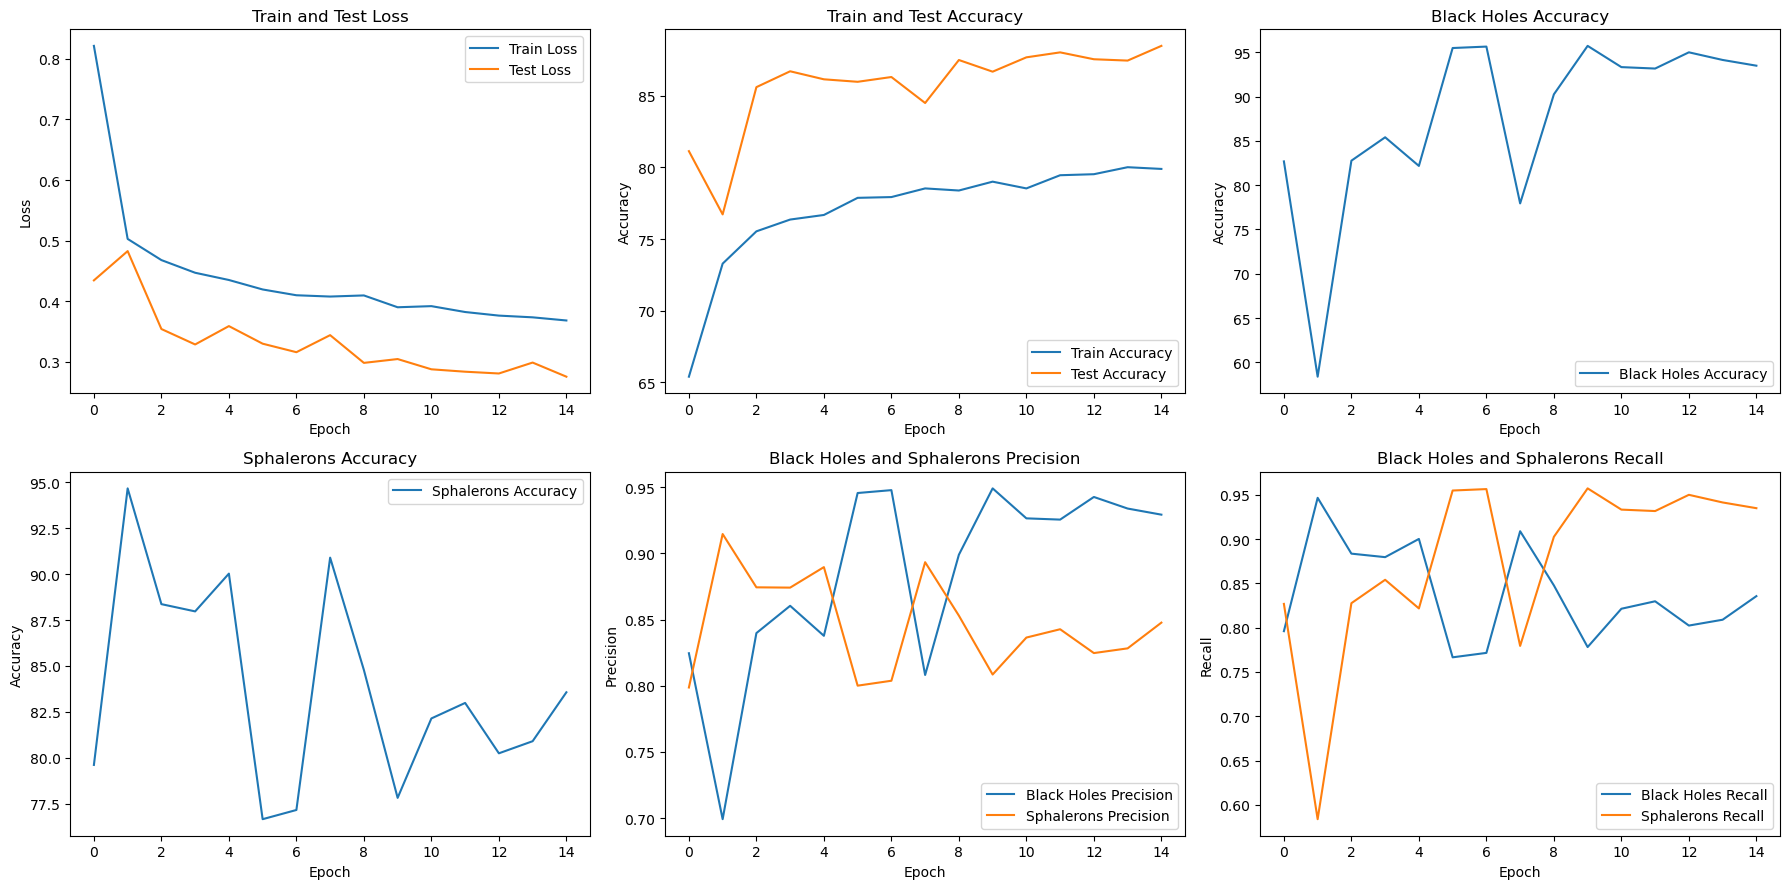

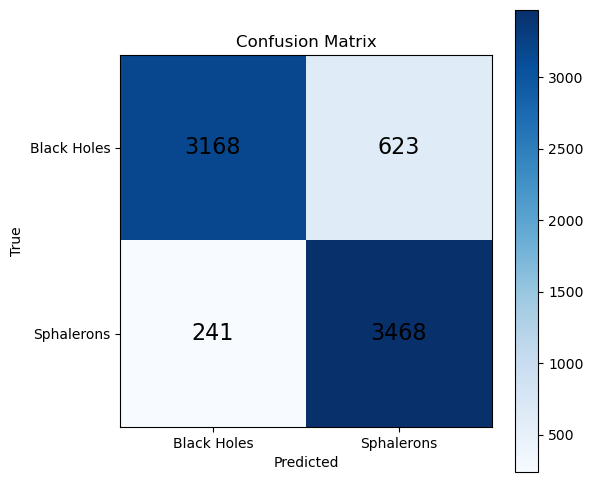

In [37]:
import trainer

n_epochs = 15
model = nnmodel.ConvModel(0.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs)
